Preprocessing
*Load data
*Visual inspection (bad channels)
*Filtering (low + high pass)
*Artefact remove (ICA?)
*Epoching (trigger values on last slide from yesterday, including base-line correcting - tmin = time before stim = 0.5s, tmax = time after stim = 1.5s, baseline = (None,0) = gives the entire baseline as a baseline)
*(once you have epochs you can start plotting - two things he said remember to plot the...)
*Reject based on values

no bad channels for participant 2 (next data file)
20 = trial go?
10 = response?

In [9]:
#%matplotlib qt
%matplotlib inline

In [10]:
import mne
import pandas as pd
import os
import numpy as np
from trigger_function import convert_triggers

## Load data

In [11]:
#Loading data
filepath = os.path.join("..", "..", "EEG_data", "p1-raw.fif")
raw = mne.io.read_raw_fif(filepath, preload=True)
raw.load_data()

Opening raw data file ..\..\EEG_data\p1-raw.fif...
    Range : 0 ... 1214579 =      0.000 ...  1214.579 secs
Ready.
Reading 0 ... 1214579  =      0.000 ...  1214.579 secs...


<Raw | p1-raw.fif, 32 x 1214580 (1214.6 s), ~296.6 MB, data loaded>

## Filtering

In [12]:
#Low pass filter first, then high pass filter (instead of both at the same time, which can produce more artifacts)
#creating a copy in order to still have the basic "raw" unchanged
raw_filtered = raw.copy().filter(l_freq=None, h_freq=40)
raw_filtered = raw_filtered.filter(l_freq=0.1, h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 33001 samples (33.001 sec)



In [13]:
#Checking if filtered as wanted
raw_filtered.info

<Info | 12 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, ...
 chs: 32 EEG
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 35 items (3 Cardinal, 32 EEG)
 experimenter: mne_anonymize
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 lowpass: 40.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 32
 projs: []
 sfreq: 1000.0 Hz
>

## Artifact corrections

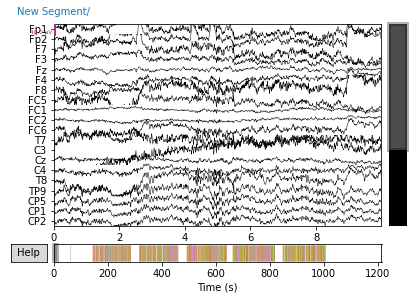

In [14]:
#looking at the channels
raw_filtered.plot();
#c3 looks bad, F8, F7 looks like they have artifacts

In [15]:
#defining C3 as a bad channe
raw_filtered.info['bads'].append('C3')

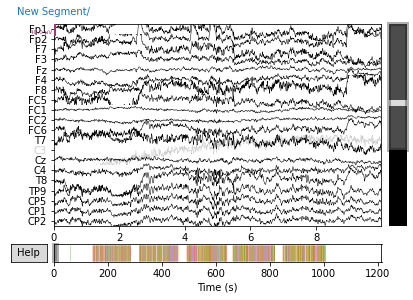

In [16]:
#plot channels after marking C3 as bad (now grey)
raw_filtered.plot();

In [17]:
# set up and fit the ICA - as many components as needed for explaining 95% of the variance - to detect noise
ica = mne.preprocessing.ICA(n_components=0.95, random_state=97, max_iter=800)
ica.fit(raw_filtered)

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by explained variance: 11 components
Fitting ICA took 19.4s.


<ICA | raw data decomposition, fit (fastica): 1214580 samples, 11 components, channels used: "eeg">

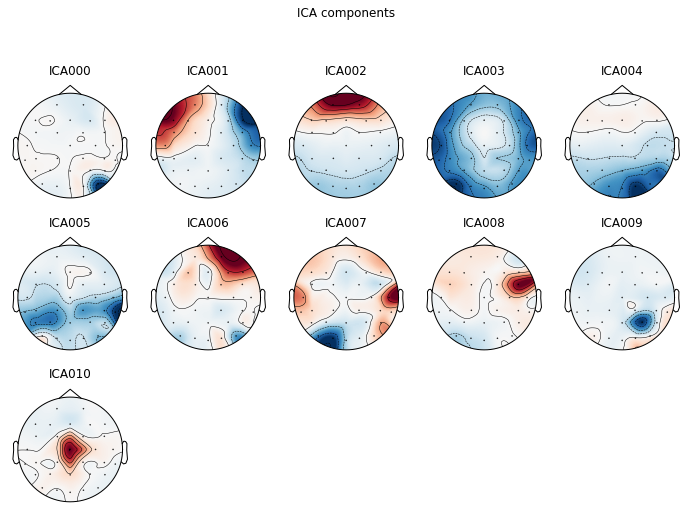

In [18]:
# Visualising components ordered by the variance that they explain (most = first)
ica.plot_components();

# These components are accumulated across time and channels - grouping components, that look alike.

Creating RawArray with float64 data, n_channels=11, n_times=1214580
    Range : 0 ... 1214579 =      0.000 ...  1214.579 secs
Ready.


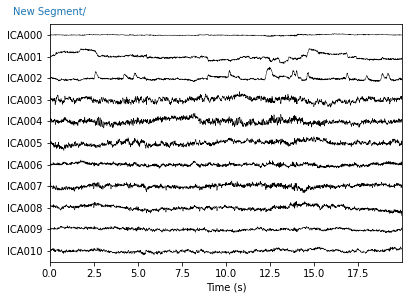

In [19]:
#Plotting the time series of the ICA (plotting the components - also to detect artifacts)
ica.plot_sources(raw_filtered, show_scrollbars=False);

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
607 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
607 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
607 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


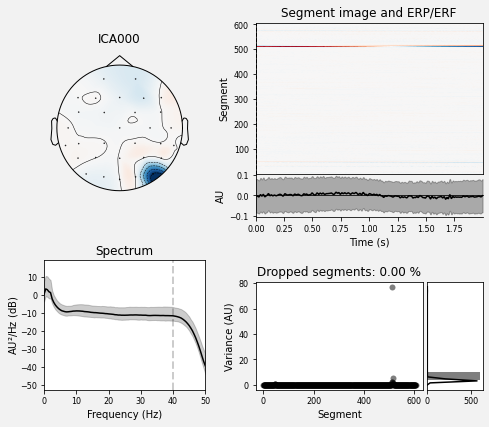

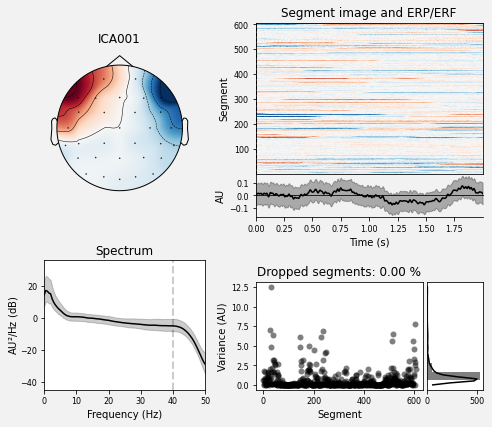

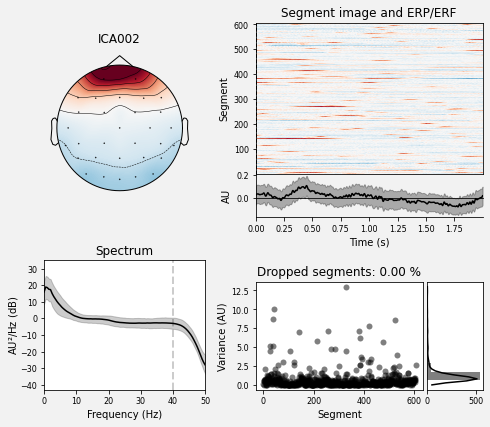

[<Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>]

In [20]:
#Plotting properties of the components we want to exclude
#Excluding 000 = muscle tensions, 001 = saccade, 002 = eye blink
ica.exclude = [0, 1, 2]
ica.plot_properties(raw_filtered, picks=ica.exclude)

In [21]:
#Applying the ICA
orig_raw = raw_filtered.copy() #making a copy first, since it changes the data to apply the ica
#raw.load_data() #might not be needed as we did preload = True earlier

#Applying the ICA (ow that the exclusions have been set, we can reconstruct the sensor signals
# with artifacts removed using the apply method)
ica.apply(raw_filtered)

Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 3 ICA components
    Projecting back using 31 PCA components


<Raw | p1-raw.fif, 32 x 1214580 (1214.6 s), ~296.6 MB, data loaded>

## Events/Epochs

In [22]:
# Defining events
events, _ = mne.events_from_annotations(raw)
print(events)
print(_)
#sample number in the first column and integer event ID in the last column;

Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 20']
[[      0       0   99999]
 [  60957       0      10]
 [ 142467       0       1]
 ...
 [1002958       0      10]
 [1003258       0       1]
 [1004718       0      12]]
{'New Segment/': 99999, 'Stimulus/S  1': 1, 'Stimulus/S 10': 10, 'Stimulus/S 11': 11, 'Stimulus/S 12': 12, 'Stimulus/S 20': 20}


In [37]:
# Trigger events - #we can provide an event dictionary that maps the integer IDs to experimental conditions or events
events, event_ids = convert_triggers(events = events, return_event_ids=True)
print(events)
print(event_ids)

[[      0       0   99999]
 [  60957       0      10]
 [ 142467       0       1]
 ...
 [1002958       0      10]
 [1003258       0       1]
 [1004718       0      12]]
{'stop_signal': 11, 'go': 10, 'response': 1, 'stop_signal_only': 12, 'failed_response': 2, 'failed_inhibition': 37, 'successful_inhibition': 35}


In [23]:
#we can provide an event dictionary that maps the integer IDs to experimental conditions or events
#event_id = {'S20': 20, 'S11': 11, 'S10': 10}

In [35]:
# Rejection parameters based on peak-to-peak amplitude
reject = dict(eeg=150e-6)  # 150 µV

# Any signal greater than 150 µV cannot be generated by a brain, thus a data quality constraint
# rejecting any epoch where peak-to-peak signal amplitude is beyond reasonable limits for that channel type.

In [38]:
# Creating epochs
epochs = mne.Epochs(raw_filtered, events, event_ids, tmin=-0.5, tmax=1.5,
                    baseline=(None,0), reject=reject, preload=True)

# We specify tmin = -0.5 and tmax = 1.5 (the time relative to each event at which to start and end each epoch).
# And put in the reject parameters based on peak-to-peak amplitude (defined above)

Not setting metadata
Not setting metadata
772 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 772 events and 2001 original time points ...
    Rejecting  epoch based on EEG : ['P8', 'O2']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['TP10']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['P4']
7 bad epochs dropped


In [39]:
epochs

Number of events,765
Events,failed_inhibition: 40failed_response: 40go: 238response: 250stop_signal: 98stop_signal_only: 49successful_inhibition: 50
Time range,-0.500 – 1.500 sec
Baseline,-0.500 – 0.000 sec


## Visualisation

<ipython-input-129-cec95dd59b2d>:2: RuntimeWarning: event 30 missing from event_id will be ignored
  mne.viz.plot_events(events=events, sfreq=raw_filtered.info['sfreq'], first_samp=raw.first_samp, event_id=event_ids);
<ipython-input-129-cec95dd59b2d>:2: RuntimeWarning: event 99999 missing from event_id will be ignored
  mne.viz.plot_events(events=events, sfreq=raw_filtered.info['sfreq'], first_samp=raw.first_samp, event_id=event_ids);


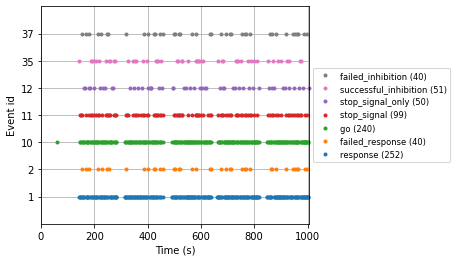

In [129]:
#Trying to plot the events
mne.viz.plot_events(events=events, sfreq=raw_filtered.info['sfreq'], first_samp=raw.first_samp, event_id=event_ids);
#about same number of successful and failed inhibition
# sample frequency is 1000 ('sfreq') = 1000 samples per second

#machine learning, classification - over tid evt (vi har gjort det) - koden er godt integreret i mne

## Comparing Evoked

To visually comparing different evoked objects it is a good idea to calculate
 a _difference  wave_, i.e. one condition minus the other condition. In
 MNE-python ```mne.combine_evokeds```can do that.

In [50]:
# The conditions we care about
conds = ['failed_inhibition', 'successful_inhibition']

#Equalize the number of trials in each conditions (as seen above, there are respectively 40 and 50)
epochs.equalize_event_counts(conds)  # this operates in-place
# Now both of the conditions have 40 trials

Dropped 10 epochs: 55, 117, 129, 135, 174, 180, 184, 389, 395, 400


(<Epochs |  755 events (all good), -0.5 - 1.5 sec, baseline -0.5 – 0 sec, ~368.9 MB, data loaded,
  'failed_inhibition': 40
  'failed_response': 40
  'go': 238
  'response': 250
  'stop_signal': 98
  'stop_signal_only': 49
  'successful_inhibition': 40>,
 array([ 55, 117, 129, 135, 174, 180, 184, 389, 395, 400], dtype=int64))

In [53]:
# Extracting failed and successful inhibition epochs
failed_inhibition_epochs = epochs['failed_inhibition']
successful_inhibition_epochs = epochs['successful_inhibition']

failed_inhibition_epochs #40 auditory events and thus epochs (same for successful)

Number of events,40
Events,failed_inhibition: 40
Time range,-0.500 – 1.500 sec
Baseline,-0.500 – 0.000 sec


Not setting metadata
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


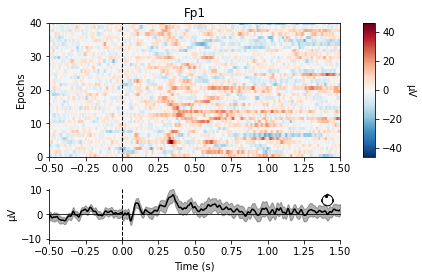

Not setting metadata
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


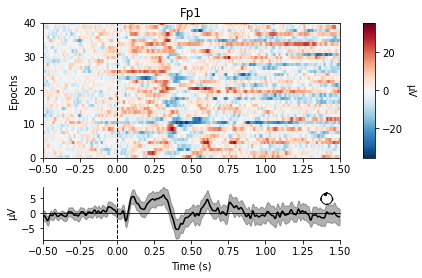

[<Figure size 432x288 with 4 Axes>]

In [56]:
# Plotting using plot_image, which shows each epoch as one row of an image map,
# with color representing signal magnitude; the average evoked response and the sensor
# location are shown below the image:

# to inspect what we have...? Looking at different channels - here Fp1 is demonstrated
# (but can be exchanged with any other channel)
failed_inhibition_epochs.plot_image(picks=['Fp1'])
successful_inhibition_epochs.plot_image(picks=['Fp1'])

In [58]:
#Averaging the epochs in each condition (failed vs. successful inhibition) to get an estimate of evoked responses
failed_evoked = failed_inhibition_epochs.average()
successful_evoked = successful_inhibition_epochs.average()

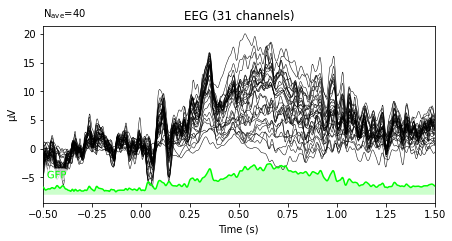

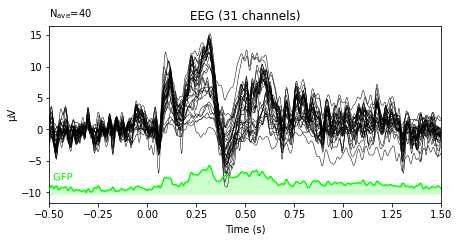

In [62]:
#Global field power plots (showing the variance aka sds)
failed_evoked.plot(gfp=True);
successful_evoked.plot(gfp=True);

#when the gfp is high, sd is big between the channels - seems like for successful, there is less variation
# between electrodes/channels, particularly between 400-1000ms. Seems more homogenous sd throughout the whole epoch
# while, there is a bigger "peak" in sd in the failed inhibition.

No projector specified for this dataset. Please consider the method self.add_proj.


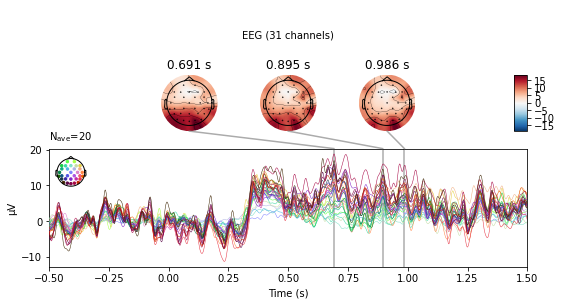

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


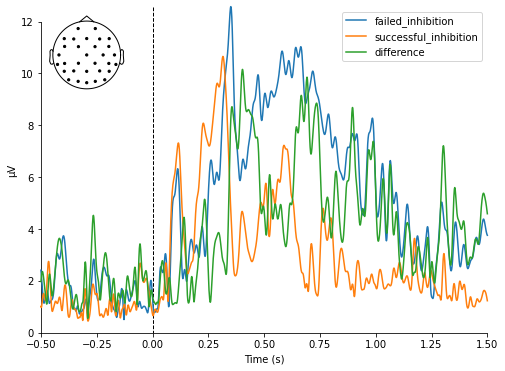

[<Figure size 576x432 with 2 Axes>]

In [73]:
# using a function from the mne.viz module to compare the global field power for each sensor
# type of the two Evoked object

#To visually compare different evoked objects it is a good idea to calculate 
# a _difference  wave_, i.e. one condition minus the other condition. In MNE-python
# mne.combine_evokeds can do that.

# Difference between the two conditions
difference_wave = mne.combine_evoked([failed_evoked, successful_evoked], weights=[1, -1])

#In the dict in the evokeds= we define which word to associate with the evoked variable to be shown on the plot
mne.viz.plot_compare_evokeds(evokeds=dict(failed_inhibition=failed_evoked, successful_inhibition=successful_evoked, difference=difference_wave),
                             legend='upper right', show_sensors='upper left')

No projector specified for this dataset. Please consider the method self.add_proj.


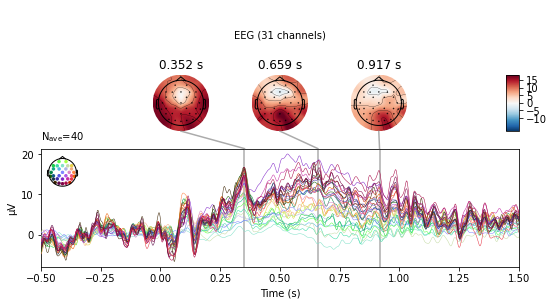

No projector specified for this dataset. Please consider the method self.add_proj.


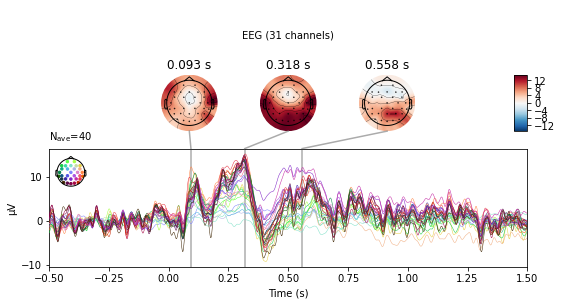

No projector specified for this dataset. Please consider the method self.add_proj.


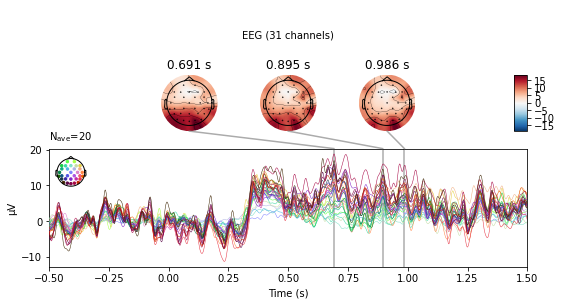

In [75]:
# Getting a more detailed view of the evoked object for failed inhibition using plot_joint and the other
failed_evoked.plot_joint(picks='eeg');
successful_evoked.plot_joint(picks='eeg');
difference_wave.plot_joint(picks='eeg');
# early components seem quite similar (related to when hearing the go sound, processing this) while later components differ
# more between failed and successful trials

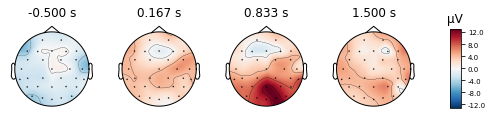

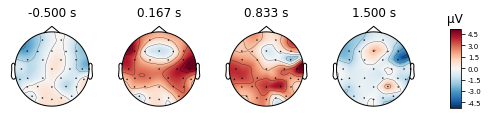

In [80]:
failed_evoked.plot_topomap(ch_type='eeg'); #it selects some relevant times
successful_evoked.plot_topomap(ch_type='eeg');

## Analysis aka Machine Learning

In [94]:
#packages needed?
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit

import mne
from mne.datasets import sample
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)

In [87]:
X = epochs[conds].get_data()  # MEG signals: n_epochs, n_meg_channels, n_times
y = epochs[conds].events[:, 2]  # target: ,2 = we want the stimulus trigger

In [91]:

print(X.shape) #trials=80, channels=32, time points=2001
print(epochs.info)

(80, 32, 2001)
<Info | 13 non-empty values
 bads: 1 items (C3)
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, ...
 chs: 32 EEG
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 35 items (3 Cardinal, 32 EEG)
 experimenter: mne_anonymize
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 lowpass: 40.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 32
 projs: []
 sfreq: 1000.0 Hz
>
[35 37 37 37 35 35 35 37 35 37 35 37 37 35 37 35 35 37 35 37 37 37 35 35
 35 37 35 37 37 37 35 37 37 35 35 35 37 37 35 35 35 37 37 35 37 35 35 37
 37 37 35 35 35 35 37 37 37 35 37 35 35 35 35 37 37 35 37 35 35 37 35 35
 37 37 37 37 35 35 37 37]


In [93]:
#Changing trigger values #35 =0 = successful, 37 =1 = failed
print(y) #which values now
y[y==35] = 0 #successful
y[y==37] = 1 #failed
print(y)

[35 37 37 37 35 35 35 37 35 37 35 37 37 35 37 35 35 37 35 37 37 37 35 35
 35 37 35 37 37 37 35 37 37 35 35 35 37 37 35 35 35 37 37 35 37 35 35 37
 37 37 35 35 35 35 37 37 37 35 37 35 35 35 35 37 37 35 37 35 35 37 35 35
 37 37 37 37 35 35 37 37]
[0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 0 1 0 1 1 1 0 0 0 1 0 1 1 1 0 1 1 0 0 0 1
 1 0 0 0 1 1 0 1 0 0 1 1 1 0 0 0 0 1 1 1 0 1 0 0 0 0 1 1 0 1 0 0 1 0 0 1 1
 1 1 0 0 1 1]


In [95]:
#cross validation
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=2021)

In [96]:
#classification
clf = make_pipeline(StandardScaler(), LinearModel(LogisticRegression()))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearmodel', LinearModel(model=LogisticRegression()))])

In [97]:
#applying classifier for each time point, with roc_auc scores
time_decod = SlidingEstimator(clf, scoring='roc_auc')

In [99]:
#getting the scores
scores = cross_val_multiscore(time_decod, X, y, cv=cv)

100%|██████████| Fitting SlidingEstimator : 2001/2001 [00:16<00:00,  118.43it/s]
100%|██████████| Fitting SlidingEstimator : 2001/2001 [00:21<00:00,   94.75it/s]
100%|██████████| Fitting SlidingEstimator : 2001/2001 [00:17<00:00,  112.67it/s]
100%|██████████| Fitting SlidingEstimator : 2001/2001 [00:20<00:00,   97.83it/s]
100%|██████████| Fitting SlidingEstimator : 2001/2001 [00:22<00:00,   90.87it/s]


In [103]:
#a score for each split (cv) and each time point
scores.shape

(5, 2001)

Text(0, 0.5, 'ROC AUC')

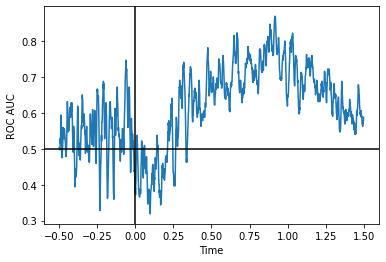

In [119]:
#plotting the scores over time
plt.plot(epochs.times, scores.mean(axis=0));
plt.axhline(0.5, color='k')
plt.axvline(0.0, color='k')
plt.xlabel("Time")
plt.ylabel("ROC AUC")

#acc before stim onset (0s) should be about chance level, and then increase
#seems like the score is best around 900ms - so at this point the model is best at classifying

In [130]:
# Fitting to get coefficients 
time_decod.fit(X, y)

coef = get_coef(time_decod, 'filters_', inverse_transform=False)
coef.shape #one coef value per per timepoint per channel

100%|██████████| Fitting SlidingEstimator : 2001/2001 [00:18<00:00,  109.77it/s]


(32, 2001)

No projector specified for this dataset. Please consider the method self.add_proj.


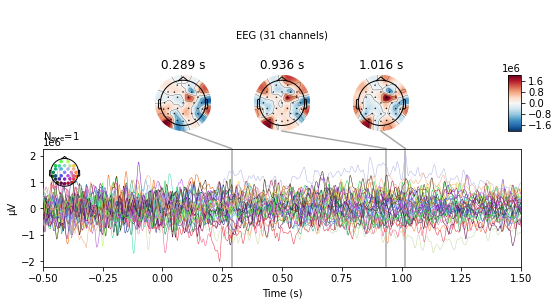

<Evoked | '' (average, N=1), -0.5 – 1.5 sec, baseline off, 32 ch, ~551 kB>


In [132]:
# Plotting coefficients
evoked_coef = mne.EvokedArray(coef,
                              epochs.info,
                              tmin=epochs.times[0],
                        )
evoked_coef.plot_joint(); 

In [ ]:
# Er det fint bare at kommentere på plottet ovenfor, eller skal man også lave en .fit efter det og kig på coefs?
# Hvad er baseline (0s) - go signal, ikke? Er det et problem ift. at no-go signalet kommer på forskellige tidspunkter?
# Deltager 2 - skal vi bruge den? eller bare en? og hvordan med bad channels?
# Filtering - hvorfor er der højere risk for artifacts ved begge filtre på samme tid